In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda
Loading data...
Loading EfficientNet model...


c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features...
Training SVM classifier...
Evaluating SVM classifier...
EfficientNet + SVM Evaluation:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00        52

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241



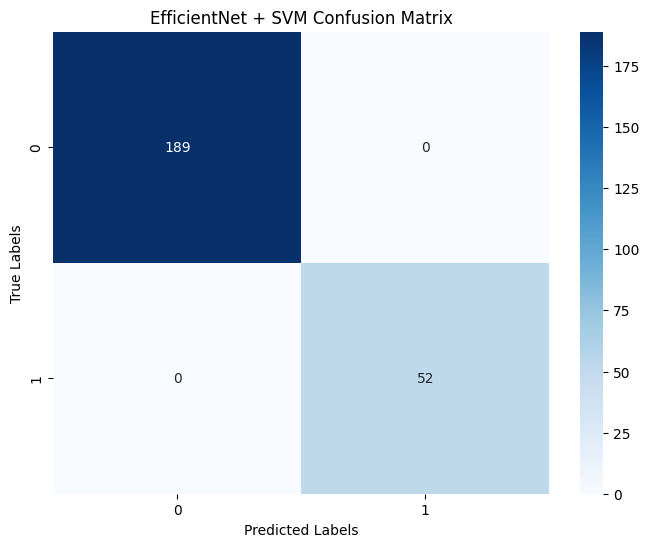

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check if CUDA (GPU) is available
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name() if torch.cuda.is_available() else "No GPU found")

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32):  # Increased batch size
    transform = transforms.Compose([
        transforms.Resize((227, 227)),  # Fixed size 227x227
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

def evaluate_classifier_and_plot_confusion_matrix(classifier, features, labels, model_name):
    predictions = classifier.predict(features)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    print(f"{model_name} Evaluation:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(classification_report(labels, predictions))

    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

def main(data_dir):
    print("Loading data...")
    train_loader, val_loader, test_loader = load_data(data_dir)

    print("Loading EfficientNet model...")
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 1024) # increased feature size
    model.avgpool = nn.AdaptiveAvgPool2d(1) #added adaptive pooling
    model = nn.Sequential(model, nn.Flatten(1)) #flatten the output

    model = model.to(device)

    # Extract features using EfficientNet
    print("Extracting features...")
    train_features, train_labels = extract_features(model, train_loader)
    val_features, val_labels = extract_features(model, val_loader)
    test_features, test_labels = extract_features(model, test_loader)

    # Train SVM classifier
    print("Training SVM classifier...")
    svm_classifier = SVC(kernel='rbf', C=1)  # You can adjust kernel and C
    svm_classifier.fit(train_features, train_labels)

    # Evaluate SVM classifier
    print("Evaluating SVM classifier...")
    evaluate_classifier_and_plot_confusion_matrix(svm_classifier, test_features, test_labels, "EfficientNet + SVM")

if __name__ == "__main__":
    data_directory = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"
    main(data_directory)

efficient model with regulization, (almost same results , can eject)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda
Loading data...
Loading EfficientNet model...
Extracting features...


c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training SVM classifier...
Evaluating SVM classifier...
EfficientNet + SVM Evaluation:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00        52

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241



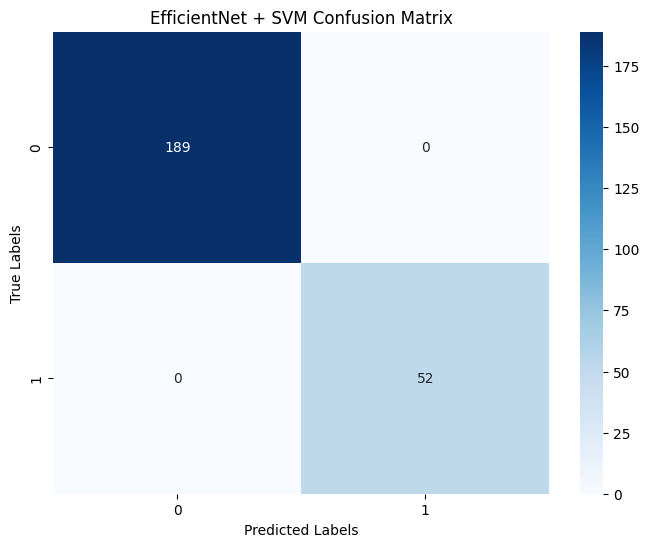

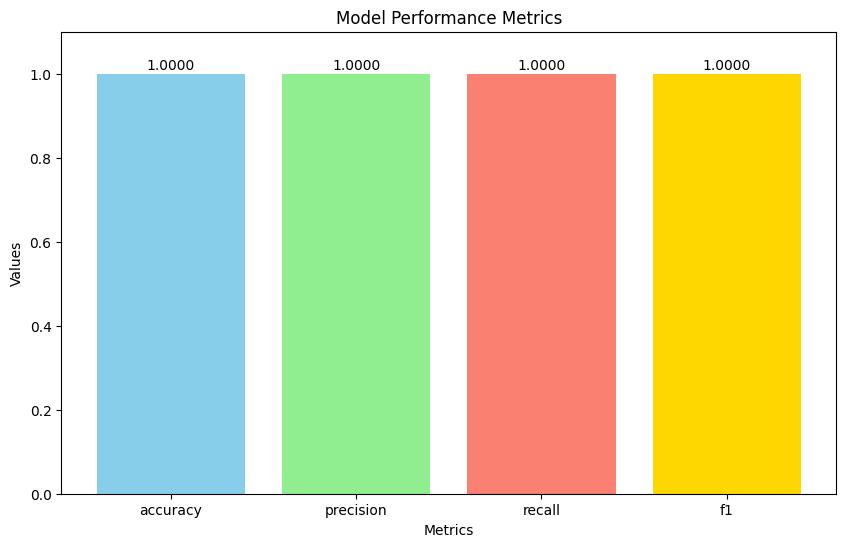

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check if CUDA (GPU) is available
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name() if torch.cuda.is_available() else "No GPU found")

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

def evaluate_classifier_and_plot_confusion_matrix(classifier, features, labels, model_name):
    predictions = classifier.predict(features)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    print(f"{model_name} Evaluation:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(classification_report(labels, predictions))

    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def main(data_dir):
    print("Loading data...")
    train_loader, val_loader, test_loader = load_data(data_dir)

    print("Loading EfficientNet model...")
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 1024)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model = nn.Sequential(model, nn.Flatten(1))

    model = model.to(device)

    print("Extracting features...")
    train_features, train_labels = extract_features(model, train_loader)
    val_features, val_labels = extract_features(model, val_loader)
    test_features, test_labels = extract_features(model, test_loader)

    print("Training SVM classifier...")
    svm_classifier = SVC(kernel='rbf', C=1)
    svm_classifier.fit(train_features, train_labels)

    print("Evaluating SVM classifier...")
    results = evaluate_classifier_and_plot_confusion_matrix(svm_classifier, test_features, test_labels, "EfficientNet + SVM")

    # Plotting Results
    plot_results(results)

def plot_results(results):
    metrics = list(results.keys())
    values = list(results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
    plt.title('Model Performance Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.ylim(0, 1.1)  # Set y-axis limit for better visualization
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')  # Add value labels
    plt.show()

if __name__ == "__main__":
    data_directory = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"
    main(data_directory)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda
Loading data...
Loading EfficientNet model...
Training EfficientNet model...


c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.3563159770435757
Epoch 1/10, Validation Loss: 0.34090206027030945
Epoch 2/10, Loss: 0.07236092330680953
Epoch 2/10, Validation Loss: 0.017659847158938646
Epoch 3/10, Loss: 0.02667210018262267
Epoch 3/10, Validation Loss: 0.008968398440629244
Epoch 4/10, Loss: 0.014613242690554924
Epoch 4/10, Validation Loss: 0.002570042386651039
Epoch 5/10, Loss: 0.013640647508307464
Epoch 5/10, Validation Loss: 0.0026693687541410327
Epoch 6/10, Loss: 0.007856603065091703
Epoch 6/10, Validation Loss: 0.002374734031036496
Epoch 7/10, Loss: 0.004887112726767858
Epoch 7/10, Validation Loss: 0.0015910299262031913
Epoch 8/10, Loss: 0.0035702020718923044
Epoch 8/10, Validation Loss: 0.0013101334334351122
Epoch 9/10, Loss: 0.004736933507956564
Epoch 9/10, Validation Loss: 0.0018029137281700969
Epoch 10/10, Loss: 0.0022856141893296605
Epoch 10/10, Validation Loss: 0.00129181076772511
Extracting features...
Training SVM classifier...
Evaluating SVM classifier...
EfficientNet + SVM Evaluation

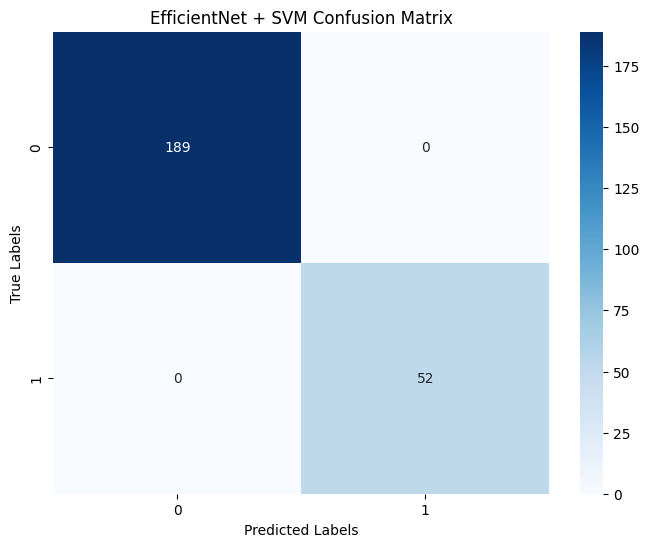

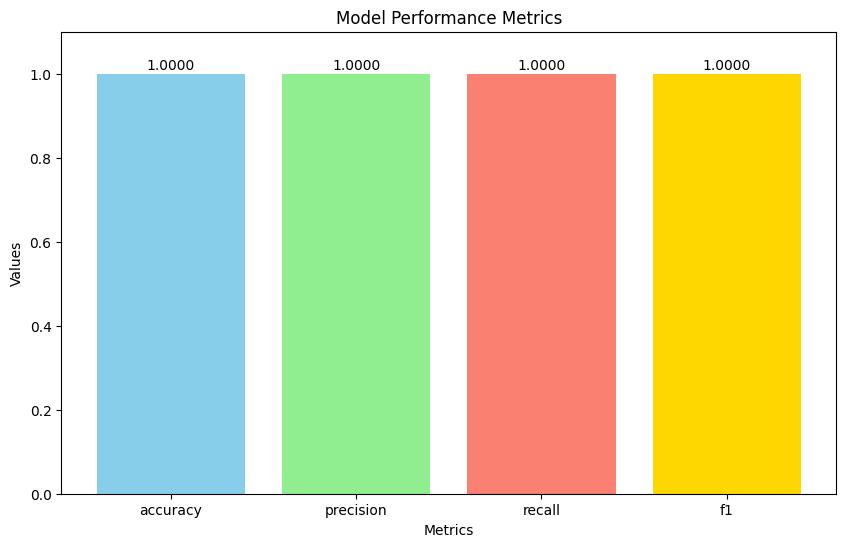

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check if CUDA (GPU) is available
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name() if torch.cuda.is_available() else "No GPU found")

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

def evaluate_classifier_and_plot_confusion_matrix(classifier, features, labels, model_name):
    predictions = classifier.predict(features)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    print(f"{model_name} Evaluation:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(classification_report(labels, predictions))

    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def train_efficientnet(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss/len(val_loader)}")

    return model

def main(data_dir):
    print("Loading data...")
    train_loader, val_loader, test_loader = load_data(data_dir)

    print("Loading EfficientNet model...")
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 2)  # 2 classes
    model = model.to(device)

    print("Training EfficientNet model...")
    model = train_efficientnet(model, train_loader, val_loader)

    print("Extracting features...")
    train_features, train_labels = extract_features(model, train_loader)
    test_features, test_labels = extract_features(model, test_loader)

    print("Training SVM classifier...")
    svm_classifier = SVC(kernel='rbf', C=1)
    svm_classifier.fit(train_features, train_labels)

    print("Evaluating SVM classifier...")
    results = evaluate_classifier_and_plot_confusion_matrix(svm_classifier, test_features, test_labels, "EfficientNet + SVM")

    # Plotting Results
    plot_results(results)

def plot_results(results):
    metrics = list(results.keys())
    values = list(results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
    plt.title('Model Performance Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.ylim(0, 1.1)
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
    plt.show()

if __name__ == "__main__":
    data_directory = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"
    main(data_directory)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda
Loading data...
Loading EfficientNet model...
Training EfficientNet model...


c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.27104737816585434
Epoch 1/10, Validation Loss: 0.23730351775884628
Epoch 2/10, Loss: 0.052567401693926916
Epoch 2/10, Validation Loss: 0.010004077106714249
Epoch 3/10, Loss: 0.024717777320701215
Epoch 3/10, Validation Loss: 0.004444626159965992
Epoch 4/10, Loss: 0.00839455609416796
Epoch 4/10, Validation Loss: 0.0031072708079591393
Epoch 5/10, Loss: 0.008639105518038074
Epoch 5/10, Validation Loss: 0.0026198718696832657
Epoch 6/10, Loss: 0.006644823497885631
Epoch 6/10, Validation Loss: 0.0016485889791511
Epoch 7/10, Loss: 0.003862155905355596
Epoch 7/10, Validation Loss: 0.0012116602738387883
Epoch 8/10, Loss: 0.0031000740483351466
Epoch 8/10, Validation Loss: 0.0010298487322870642
Epoch 9/10, Loss: 0.003070995179263668
Epoch 9/10, Validation Loss: 0.0010959072969853878
Epoch 10/10, Loss: 0.0024558900590313393
Epoch 10/10, Validation Loss: 0.0007530788134317845
Evaluating EfficientNet model...
EfficientNet Evaluation:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall

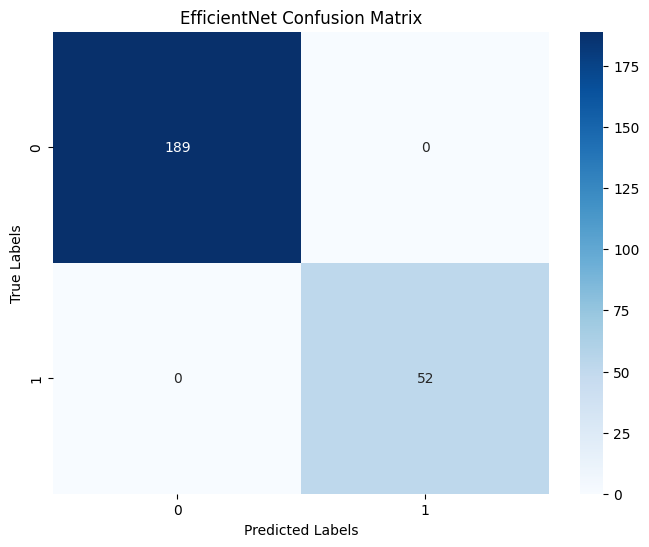

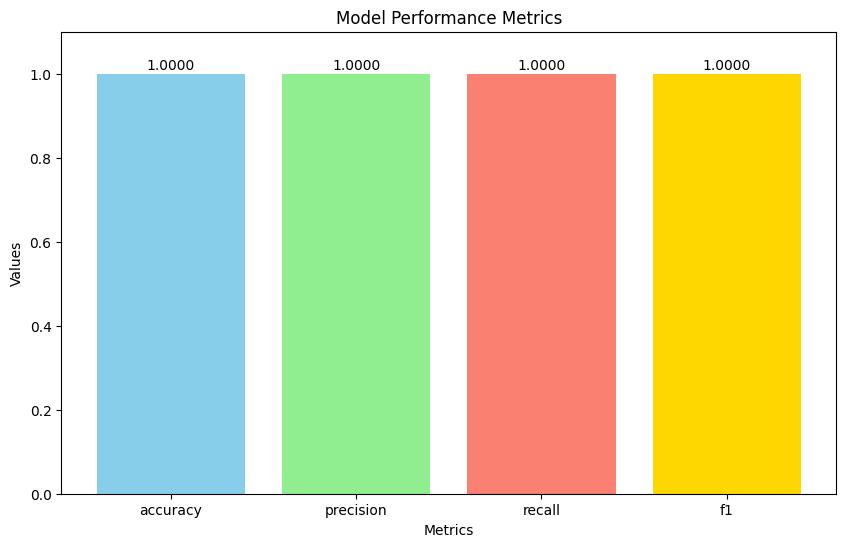

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check if CUDA (GPU) is available
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name() if torch.cuda.is_available() else "No GPU found")

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

def train_efficientnet(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss/len(val_loader)}")

    return model

def evaluate_efficientnet(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("EfficientNet Evaluation:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('EfficientNet Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def plot_results(results):
    metrics = list(results.keys())
    values = list(results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
    plt.title('Model Performance Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.ylim(0, 1.1)
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
    plt.show()

def main(data_dir):
    print("Loading data...")
    train_loader, val_loader, test_loader = load_data(data_dir)

    print("Loading EfficientNet model...")
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 2)  # 2 classes
    model = model.to(device)

    print("Training EfficientNet model...")
    model = train_efficientnet(model, train_loader, val_loader)

    print("Evaluating EfficientNet model...")
    results = evaluate_efficientnet(model, test_loader)

    # Plotting Results
    plot_results(results)

if __name__ == "__main__":
    data_directory = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"
    main(data_directory)

In [ ]:
##breaking the code down


In [8]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image

# Define your data directory
data_dir = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32, image_size=227): #Added image_size parameter
    """Loads data, returning DataLoaders."""

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)), # Added resize transform
        transforms.ToTensor(),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

# Load data
train_loader, val_loader, test_loader = load_data(data_dir)

# Example usage (to check the data loaders)
# for images, labels in train_loader:
#     print("Image batch shape:", images.shape)
#     print("Label batch shape:", labels.shape)
#     break

# Example to check the first label batch.
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch:", labels)
    break

Image batch shape: torch.Size([32, 3, 227, 227])
Label batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0])


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
import numpy as np

# Define your data directory
data_dir = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32, image_size=227):
    """Loads data with preprocessing, returning DataLoaders."""

    transform = transforms.Compose([
        transforms.Lambda(lambda img: ImageOps.grayscale(img)),  # Convert to grayscale
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),  # Smoothen
        transforms.Lambda(lambda img: ImageOps.autocontrast(img)),  # Contrast stretching
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

# Load data
train_loader, val_loader, test_loader = load_data(data_dir)

# Example usage (to check the data loaders)
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break

In [9]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
import numpy as np

# Define your data directory
data_dir = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32, image_size=227):
    """Loads data with preprocessing, returning DataLoaders."""

    transform = transforms.Compose([
        transforms.Lambda(lambda img: ImageOps.grayscale(img)),  # Convert to grayscale
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),  # Smoothen
        transforms.Lambda(lambda img: ImageOps.autocontrast(img)),  # Contrast stretching
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

# Load data
train_loader, val_loader, test_loader = load_data(data_dir)

# Example usage (to check the data loaders)
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break

Image batch shape: torch.Size([32, 1, 227, 227])
Label batch shape: torch.Size([32])


In [11]:
import torch
import torchvision.models as models
from torchsummary import summary

# Load the EfficientNet-B0 model (you can change 'efficientnet_b0' to other variants)
model = models.efficientnet_b0(pretrained=True)

# Print a summary of the model
# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model = model.to(device)

# Print the model summary
summary(model, (3, 224, 224)) # Input shape (channels, height, width)

c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loading and preprocessing (same as before)
data_dir = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32, image_size=224):
    transform = transforms.Compose([
        transforms.Lambda(lambda img: ImageOps.grayscale(img)),
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),
        transforms.Lambda(lambda img: ImageOps.autocontrast(img)),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data(data_dir)

# Load EfficientNet model
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Adjust output size to 2 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

# Evaluation on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(all_labels, all_preds))
print(f"Accuracy: {accuracy_score(all_labels, all_preds)}")

c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 1, 224, 224] to have 3 channels, but got 1 channels instead

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load EfficientNet model
model = models.efficientnet_b0(pretrained=True)

# Modify the first convolutional layer for grayscale input
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Adjust output size to 2 classes
model = model.to(device)

c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.3496, Train Acc: 94.33%, Val Loss: 0.6740, Val Acc: 71.43%
Epoch [2/10], Train Loss: 0.0768, Train Acc: 100.00%, Val Loss: 0.6088, Val Acc: 66.07%
Epoch [3/10], Train Loss: 0.0351, Train Acc: 99.65%, Val Loss: 0.2207, Val Acc: 98.21%
Epoch [4/10], Train Loss: 0.0207, Train Acc: 99.82%, Val Loss: 0.0846, Val Acc: 100.00%
Epoch [5/10], Train Loss: 0.0084, Train Acc: 100.00%, Val Loss: 0.0050, Val Acc: 100.00%
Epoch [6/10], Train Loss: 0.0099, Train Acc: 100.00%, Val Loss: 0.0023, Val Acc: 100.00%
Epoch [7/10], Train Loss: 0.0083, Train Acc: 100.00%, Val Loss: 0.0026, Val Acc: 100.00%
Epoch [8/10], Train Loss: 0.0055, Train Acc: 100.00%, Val Loss: 0.0020, Val Acc: 100.00%
Epoch [9/10], Train Loss: 0.0050, Train Acc: 100.00%, Val Loss: 0.0009, Val Acc: 100.00%
Epoch [10/10], Train Loss: 0.0038, Train Acc: 100.00%, Val Loss: 0.0007, Val Acc: 100.00%


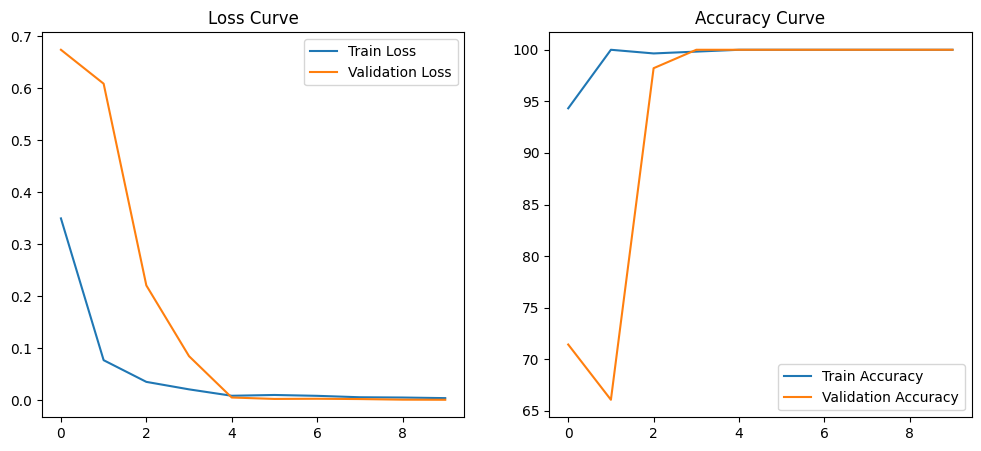

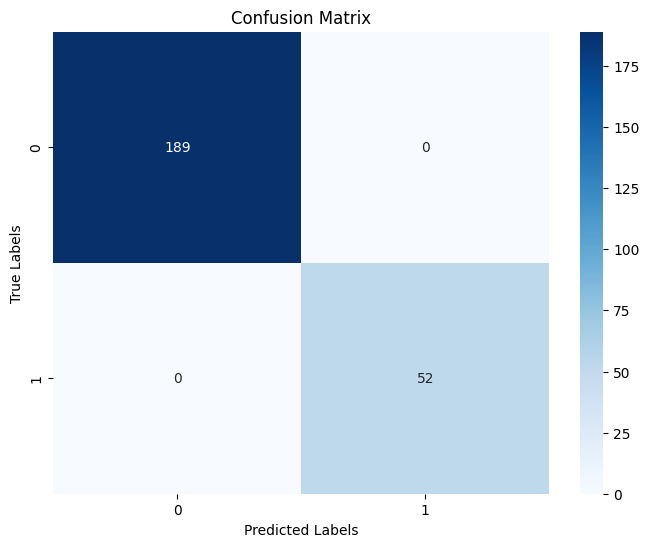

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00        52

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241

Accuracy: 1.0


In [16]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image, ImageOps, ImageFilter

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32, image_size=224):
    transform = transforms.Compose([
        transforms.Lambda(lambda img: ImageOps.grayscale(img)),
        transforms.Lambda(lambda img: img.convert('RGB')),#convert grayscale to RGB
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),
        transforms.Lambda(lambda img: ImageOps.autocontrast(img)),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data(data_dir)

# Load EfficientNet model
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Adjust output size to 2 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

# Evaluation on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(all_labels, all_preds))
print(f"Accuracy: {accuracy_score(all_labels, all_preds)}")

efficient model with regulization, (almost same results , can eject)

c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.3594, Train Acc: 93.97%, Val Loss: 0.7035, Val Acc: 33.93%
Epoch [2/10], Train Loss: 0.0818, Train Acc: 99.47%, Val Loss: 0.5758, Val Acc: 78.57%
Epoch [3/10], Train Loss: 0.0209, Train Acc: 100.00%, Val Loss: 0.2719, Val Acc: 82.14%
Epoch [4/10], Train Loss: 0.0130, Train Acc: 100.00%, Val Loss: 0.2918, Val Acc: 78.57%
Epoch [5/10], Train Loss: 0.0167, Train Acc: 99.65%, Val Loss: 0.0444, Val Acc: 100.00%
Epoch [6/10], Train Loss: 0.0191, Train Acc: 99.47%, Val Loss: 0.0024, Val Acc: 100.00%
Epoch [7/10], Train Loss: 0.0111, Train Acc: 99.65%, Val Loss: 0.0019, Val Acc: 100.00%
Epoch [8/10], Train Loss: 0.0050, Train Acc: 100.00%, Val Loss: 0.0013, Val Acc: 100.00%
Epoch [9/10], Train Loss: 0.0045, Train Acc: 100.00%, Val Loss: 0.0016, Val Acc: 100.00%
Epoch [10/10], Train Loss: 0.0034, Train Acc: 100.00%, Val Loss: 0.0010, Val Acc: 100.00%


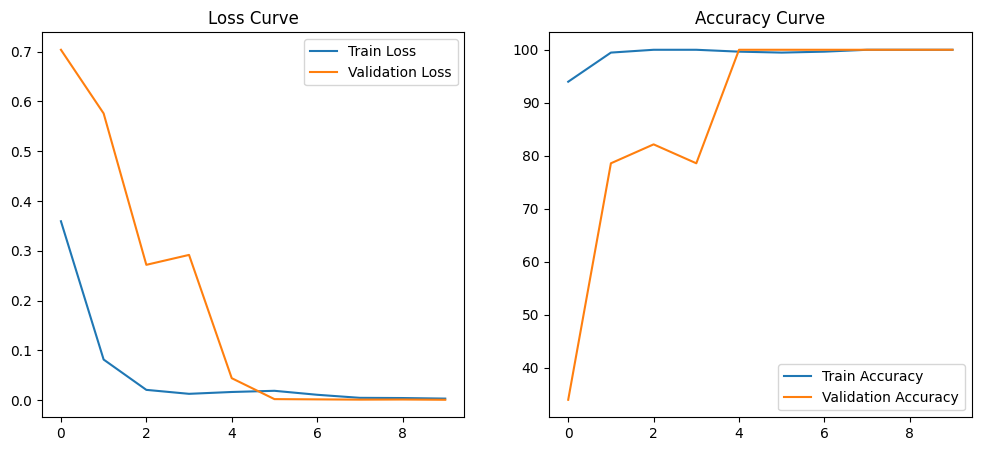

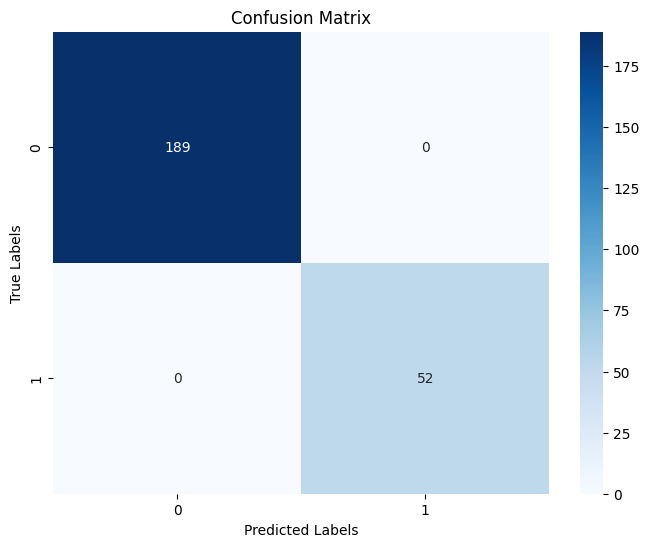

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00        52

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241

Accuracy: 1.0


In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loading and preprocessing (same as before)
data_dir = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32, image_size=224):
    transform = transforms.Compose([
        transforms.Lambda(lambda img: ImageOps.grayscale(img)),
        transforms.Lambda(lambda img: img.convert('RGB')),
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),
        transforms.Lambda(lambda img: ImageOps.autocontrast(img)),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data(data_dir)

# Load EfficientNet model
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Adjust output size to 2 classes
model = model.to(device)

# Loss and optimizer with regularization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) #L2 Regularization

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

# Evaluation on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(all_labels, all_preds))
print(f"Accuracy: {accuracy_score(all_labels, all_preds)}")

GOOGLE NET MODEL

c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.2192, Train Acc: 94.86%, Val Loss: 0.2734, Val Acc: 98.21%
Epoch [2/10], Train Loss: 0.0223, Train Acc: 100.00%, Val Loss: 0.0680, Val Acc: 100.00%
Epoch [3/10], Train Loss: 0.0097, Train Acc: 100.00%, Val Loss: 0.0091, Val Acc: 100.00%
Epoch [4/10], Train Loss: 0.0059, Train Acc: 100.00%, Val Loss: 0.0043, Val Acc: 100.00%
Epoch [5/10], Train Loss: 0.0051, Train Acc: 100.00%, Val Loss: 0.0039, Val Acc: 100.00%
Epoch [6/10], Train Loss: 0.0041, Train Acc: 100.00%, Val Loss: 0.0031, Val Acc: 100.00%
Epoch [7/10], Train Loss: 0.0032, Train Acc: 100.00%, Val Loss: 0.0021, Val Acc: 100.00%
Epoch [8/10], Train Loss: 0.0022, Train Acc: 100.00%, Val Loss: 0.0016, Val Acc: 100.00%
Epoch [9/10], Train Loss: 0.0021, Train Acc: 100.00%, Val Loss: 0.0017, Val Acc: 100.00%
Epoch [10/10], Train Loss: 0.0023, Train Acc: 100.00%, Val Loss: 0.0016, Val Acc: 100.00%


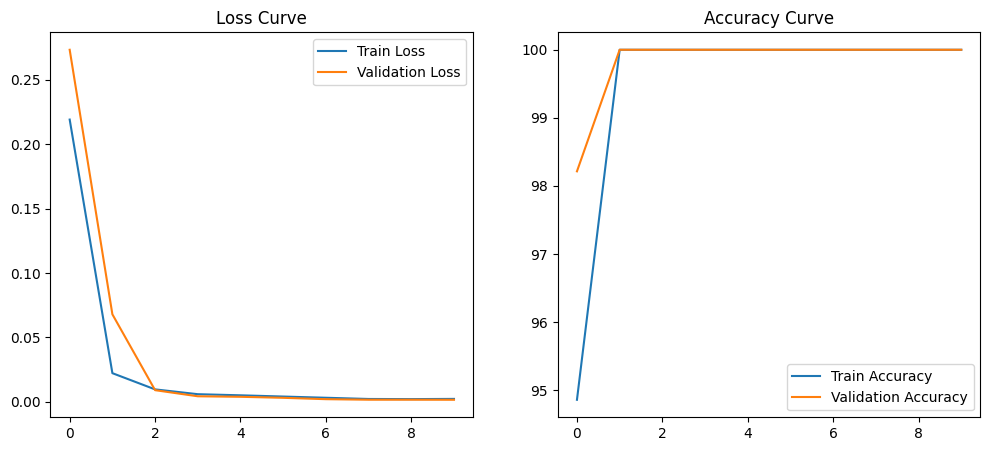

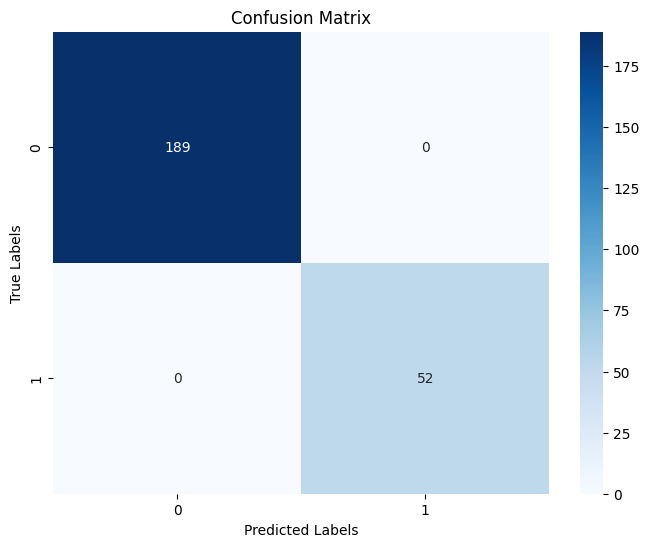

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00        52

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241

Accuracy: 1.0


In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loading and preprocessing (same as before)
data_dir = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32, image_size=224):
    transform = transforms.Compose([
        transforms.Lambda(lambda img: ImageOps.grayscale(img)),
        transforms.Lambda(lambda img: img.convert('RGB')),
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),
        transforms.Lambda(lambda img: ImageOps.autocontrast(img)),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data(data_dir)

# Load GoogLeNet model
model = models.googlenet(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Adjust output size to 2 classes
model = model.to(device)

# Loss and optimizer with regularization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) #L2 Regularization

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

# Evaluation on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(all_labels, all_preds))
print(f"Accuracy: {accuracy_score(all_labels, all_preds)}")

U net model

Using device: cuda
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 1/30
Train Loss: 0.2782 | Val Loss: 0.1987
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 2/30
Train Loss: 0.1823 | Val Loss: 0.1680
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 3/30
Train Loss: 0.1572 | Val Loss: 0.1463
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 4/30
Train Loss: 0.1366 | Val Loss: 0.1304
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 5/30
Train Loss: 0.1201 | Val Loss: 0.1131
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 6/30
Train Loss: 0.1061 | Val Loss: 0.1000
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 7/30
Train Loss: 0.0941 | Val Loss: 0.0871
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 8/30
Train Loss: 0.0838 | Val Loss: 0.0799
Model saved to C:\Users\chris/saved_models\su

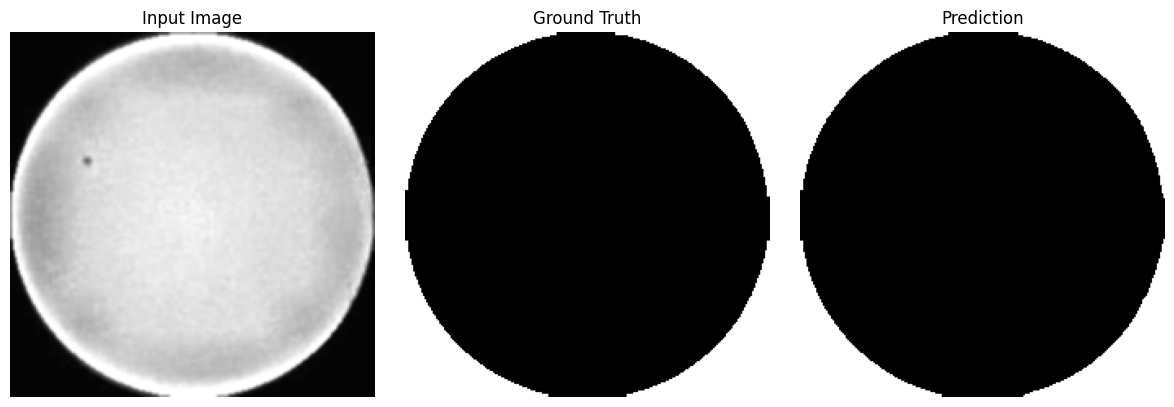

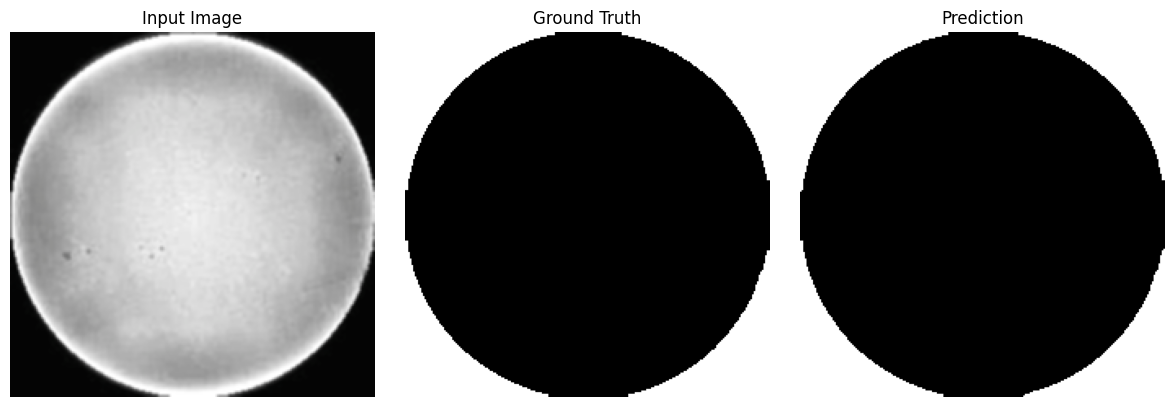

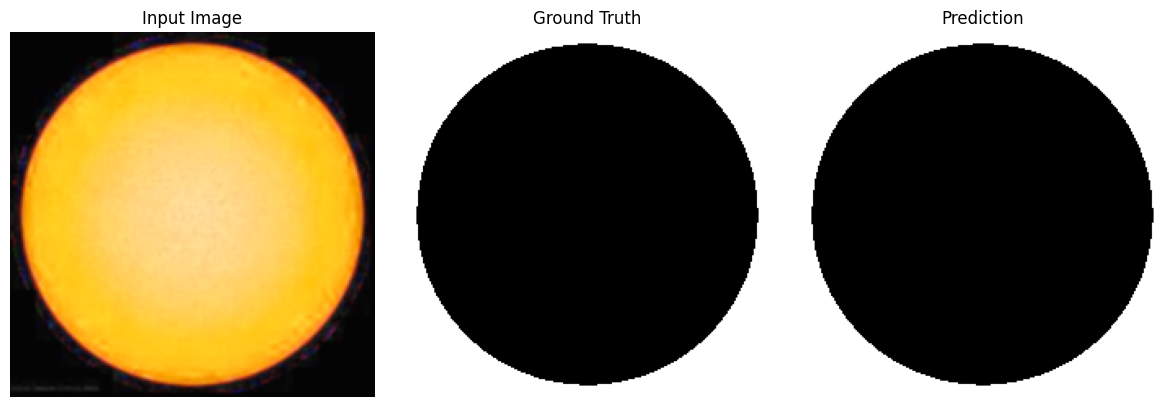


Evaluation Metrics:
Precision: 0.9990
Recall: 0.9981
F1: 0.9985
Jaccard: 0.9971
Sunspot Ratio: 0.5521166


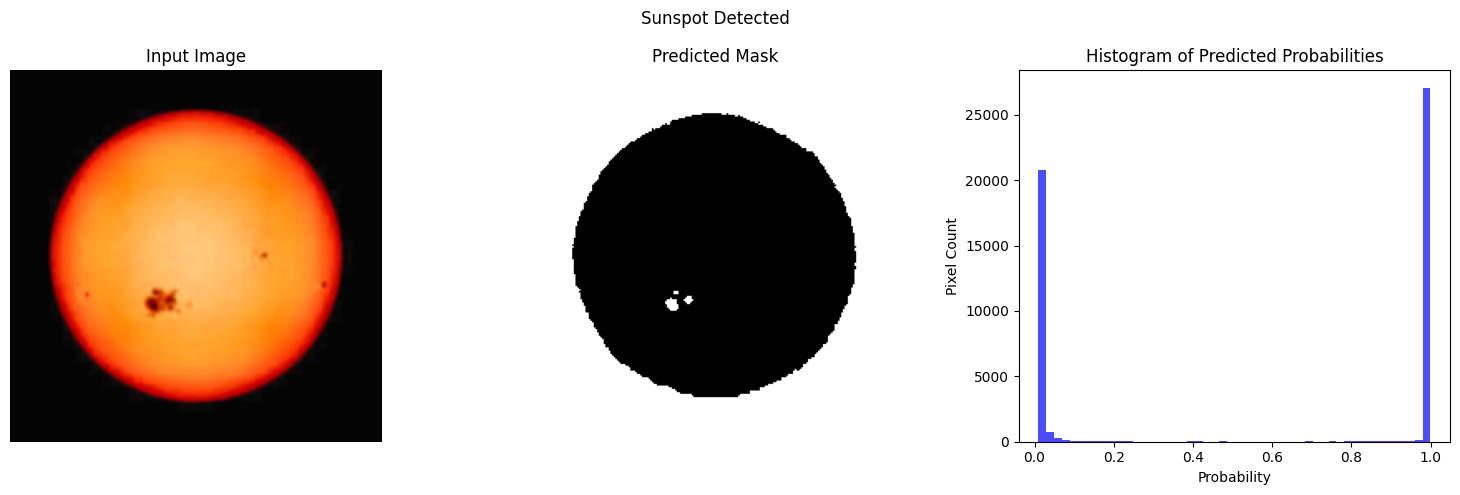

Sunspot Detected


In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skimage import measure
from sklearn.metrics import precision_recall_fscore_support, jaccard_score
from torchvision import transforms

# Check for MPS availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ================ Dataset Implementation ================
class SunspotDataset(Dataset):
    def __init__(self, img_dir, img_size=(224, 224)):  # Adjusted image size
        self.img_dir = img_dir
        self.img_size = img_size
        self.img_files = [f for f in os.listdir(img_dir)
                          if os.path.isfile(os.path.join(img_dir, f)) and
                          f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.img_files)

    def _correct_limb_darkening(self, image):
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        radius = min(w, h) // 2
        Y, X = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
        normalized_dist = np.clip(dist_from_center / radius, 0, 1)
        a, b, c = 0.3, 0.5, 0.2
        correction = 1 / (1 - a * (1 - np.sqrt(1 - normalized_dist**2)) - 
                             b * (1 - np.sqrt(1 - normalized_dist**2))**2 - 
                             c * (1 - np.sqrt(1 - normalized_dist**2))**3)
        corrected_img = image.copy().astype(np.float32)
        for i in range(3):
            channel = corrected_img[:, :, i]
            solar_disk_mask = dist_from_center <= radius
            channel[solar_disk_mask] = channel[solar_disk_mask] * correction[solar_disk_mask]
        corrected_img = np.clip(corrected_img, 0, 255).astype(np.uint8)
        return corrected_img

    def _enhance_contrast(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        enhanced_lab = cv2.merge((cl, a, b))
        enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
        return enhanced_rgb

    def _reduce_noise(self, image):
        return cv2.GaussianBlur(image, (3, 3), 0)  # Smaller kernel

    def preprocess_image(self, image_path):
        """Apply preprocessing to a solar image"""
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image at {image_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)
        image = self._correct_limb_darkening(image)
        image = self._enhance_contrast(image)
        image = self._reduce_noise(image)
        return image

    def generate_mask(self, image):
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
        gray_float = (255 - gray.astype(np.float32)) / 255.0
        normalized = cv2.normalize(gray_float, None, 0, 1, cv2.NORM_MINMAX)
        _, binary = cv2.threshold((normalized * 255).astype(np.uint8), 0, 255,
                                    cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
        labeled_array, num_features = measure.label(opening, return_num=True)
        component_sizes = np.bincount(labeled_array.ravel())
        small_size_threshold = 20  # Reduced threshold for smaller images
        too_small = component_sizes < small_size_threshold
        too_small[0] = False
        labeled_array[np.isin(labeled_array, np.where(too_small)[0])] = 0
        final_mask = labeled_array > 0
        return final_mask.astype(np.uint8) * 255

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        proc_img = self.preprocess_image(img_path)
        mask = self.generate_mask(proc_img)

        # Convert to PyTorch tensors and normalize
        image_tensor = torch.from_numpy(proc_img).permute(2, 0, 1).float() / 255.0
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).float() / 255.0

        return image_tensor, mask_tensor

# ================ Minimal U-Net Model Implementation ================
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128]): # increased features
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        # Downward path
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Upward path
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

# ================ Training Function ================
def train_model(model, train_loader, val_loader, epochs=20, lr=1e-4, accumulation_steps=4):
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5) #L2 Regularization
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
    criterion = nn.BCEWithLogitsLoss()

    best_loss = float('inf')
    train_losses, val_losses = [], []

    save_dir = os.path.expanduser("~/saved_models")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, "sunspot_unet_minimal.pth")

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        optimizer.zero_grad()

        for i, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks) / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

            epoch_train_loss += loss.item() * accumulation_steps * images.size(0)

            del images, masks, outputs
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                epoch_val_loss += loss.item() * images.size(0)

                del images, masks, outputs
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        train_loss = epoch_train_loss / len(train_loader.dataset)
        val_loss = epoch_val_loss / len(val_loader.dataset)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            try:
                torch.save(model.state_dict(), model_path)
                print(f"Model saved to {model_path}")
            except Exception as e:
                print(f"Failed to save model: {e}")
                fallback_path = os.path.expanduser("~/sunspot_unet_minimal.pth")
                try:
                    torch.save(model.state_dict(), fallback_path)
                    print(f"Model saved to fallback location: {fallback_path}")
                    model_path = fallback_path
                except Exception as e2:
                    print(f"Failed to save to fallback location as well: {e2}")

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()

    plot_path = os.path.join(save_dir, 'loss_plot.png')
    try:
        plt.savefig(plot_path)
        print(f"Plot saved to {plot_path}")
    except Exception as e:
        print(f"Failed to save plot: {e}")
        fallback_plot = os.path.expanduser("~/loss_plot.png")
        try:
            plt.savefig(fallback_plot)
            print(f"Plot saved to fallback location: {fallback_plot}")
        except Exception as e2:
            print(f"Failed to save plot to fallback location as well: {e2}")

    plt.close()
    return model_path

# ================ Evaluation and Visualization Function ================
def evaluate_model(model, test_loader, threshold=0.5, visualize=True, num_visualizations=3):
    model.eval()
    all_preds = []
    all_targets = []
    all_images = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > threshold).float()

            all_images.append(images.cpu())
            all_preds.append(preds.cpu())
            all_targets.append(masks.cpu())

    all_images = torch.cat(all_images, dim=0)
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    preds_flat = all_preds.numpy().flatten()
    targets_flat = all_targets.numpy().flatten()

    precision, recall, f1, _ = precision_recall_fscore_support(targets_flat, preds_flat, average='binary')
    jaccard = jaccard_score(targets_flat, preds_flat)

    metrics = {"precision": precision, "recall": recall, "f1": f1, "jaccard": jaccard}

    if visualize:
        num_samples = min(num_visualizations, all_images.shape[0])
        indices = np.random.choice(all_images.shape[0], num_samples, replace=False)
        for idx in indices:
            img = all_images[idx].permute(1, 2, 0).numpy()
            gt_mask = all_targets[idx].squeeze(0).numpy()
            pred_mask = all_preds[idx].squeeze(0).numpy()

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(img)
            axs[0].set_title("Input Image")
            axs[0].axis("off")

            axs[1].imshow(gt_mask, cmap='gray')
            axs[1].set_title("Ground Truth")
            axs[1].axis("off")

            axs[2].imshow(pred_mask, cmap='gray')
            axs[2].set_title("Prediction")
            axs[2].axis("off")

            plt.tight_layout()
            plt.show()

    return metrics

# ================ Single Image Inference Function ================
def infer_single_image(image_path, model, threshold=0.5, visualize=True):
    temp_dataset = SunspotDataset(os.path.dirname(image_path))

    image = temp_dataset.preprocess_image(image_path)
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        prob = torch.sigmoid(output)
        pred_mask = (prob > threshold).float().cpu().squeeze(0).squeeze(0).numpy()

    detection_threshold = 0.15
    sunspot_ratio = np.mean(pred_mask)
    print("Sunspot Ratio:", sunspot_ratio)

    if sunspot_ratio > detection_threshold:
        result = "Sunspot Detected"
    else:
        result = "No Sunspot Detected"

    if visualize:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(image)
        axs[0].set_title("Input Image")
        axs[0].axis("off")

        axs[1].imshow(pred_mask, cmap='gray', vmin=0, vmax=1)
        axs[1].set_title("Predicted Mask")
        axs[1].axis("off")

        prob_values = prob.cpu().numpy().flatten()
        axs[2].hist(prob_values, bins=50, color='blue', alpha=0.7)
        axs[2].set_title("Histogram of Predicted Probabilities")
        axs[2].set_xlabel("Probability")
        axs[2].set_ylabel("Pixel Count")

        plt.suptitle(result)
        plt.tight_layout()
        plt.show()

    print(result)
    return result

# ================ Main Execution ================
def main(data_dir):
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')

    train_dataset = SunspotDataset(train_dir)
    test_dataset = SunspotDataset(test_dir)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    batch_size = 2
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = UNet(in_channels=3, out_channels=1, features=[64, 128]) # Increased features

    model_path = train_model(model, train_loader, val_loader, epochs=30, accumulation_steps=4)

    try:
        model.load_state_dict(torch.load(model_path))
        print(f"Model loaded from {model_path}")
    except Exception as e:
        print(f"Failed to load model: {e}")
        print("Using current model state for evaluation")

    metrics = evaluate_model(model, test_loader, visualize=True, num_visualizations=3)

    print("\nEvaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

    new_image_path = r"C:\Users\chris\Downloads\sunspot -1.jpg"
    infer_single_image(new_image_path, model)

    return model, metrics

if __name__ == "__main__":
    data_directory = r"C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"
    main(data_directory)


In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skimage import measure
from sklearn.metrics import precision_recall_fscore_support, jaccard_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, roc_auc_score
import seaborn as sns

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ================ Dataset Implementation ================
class SunspotDataset(Dataset):
    def __init__(self, img_dir, img_size=(224, 224)):
        self.img_dir = img_dir
        self.img_size = img_size
        self.img_files = [f for f in os.listdir(img_dir)
                          if os.path.isfile(os.path.join(img_dir, f)) and
                          f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.img_files)

    def _correct_limb_darkening(self, image):
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        radius = min(w, h) // 2
        Y, X = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
        normalized_dist = np.clip(dist_from_center / radius, 0, 1)
        a, b, c = 0.3, 0.5, 0.2
        correction = 1 / (1 - a * (1 - np.sqrt(1 - normalized_dist**2)) -
                             b * (1 - np.sqrt(1 - normalized_dist**2))**2 -
                             c * (1 - np.sqrt(1 - normalized_dist**2))**3)
        corrected_img = image.copy().astype(np.float32)
        for i in range(3):
            channel = corrected_img[:, :, i]
            solar_disk_mask = dist_from_center <= radius
            channel[solar_disk_mask] = channel[solar_disk_mask] * correction[solar_disk_mask]
        corrected_img = np.clip(corrected_img, 0, 255).astype(np.uint8)
        return corrected_img

    def _enhance_contrast(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        enhanced_lab = cv2.merge((cl, a, b))
        enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
        return enhanced_rgb

    def _reduce_noise(self, image):
        return cv2.GaussianBlur(image, (3, 3), 0)

    def preprocess_image(self, image_path):
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image at {image_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)
        image = self._correct_limb_darkening(image)
        image = self._enhance_contrast(image)
        image = self._reduce_noise(image)
        return image

    def generate_mask(self, image):
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
        gray_float = (255 - gray.astype(np.float32)) / 255.0
        normalized = cv2.normalize(gray_float, None, 0, 1, cv2.NORM_MINMAX)
        _, binary = cv2.threshold((normalized * 255).astype(np.uint8), 0, 255,
                                    cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
        labeled_array, num_features = measure.label(opening, return_num=True)
        component_sizes = np.bincount(labeled_array.ravel())
        small_size_threshold = 20
        too_small = component_sizes < small_size_threshold
        too_small[0] = False
        labeled_array[np.isin(labeled_array, np.where(too_small)[0])] = 0
        final_mask = labeled_array > 0
        return final_mask.astype(np.uint8) * 255

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        proc_img = self.preprocess_image(img_path)
        mask = self.generate_mask(proc_img)

        image_tensor = torch.from_numpy(proc_img).permute(2, 0, 1).float() / 255.0
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).float() / 255.0

        return image_tensor, mask_tensor

# ================ Minimal U-Net Model Implementation ================
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

# ================ Training Function ================
def train_model(model, train_loader, val_loader, epochs=20, lr=1e-4, accumulation_steps=4):
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
    criterion = nn.BCEWithLogitsLoss()

    best_loss = float('inf')
    train_losses, val_losses = [], []

    save_dir = os.path.expanduser("~/saved_models")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, "sunspot_unet_minimal.pth")

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        optimizer.zero_grad()

        for i, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks) / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

            epoch_train_loss += loss.item() * accumulation_steps * images.size(0)

            del images, masks, outputs
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                epoch_val_loss += loss.item() * images.size(0)

                del images, masks, outputs
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        train_loss = epoch_train_loss / len(train_loader.dataset)
        val_loss = epoch_val_loss / len(val_loader.dataset)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            try:
                torch.save(model.state_dict(), model_path)
                print(f"Model saved to {model_path}")
            except Exception as e:
                print(f"Failed to save model: {e}")
                fallback_path = os.path.expanduser("~/sunspot_unet_minimal.pth")
                try:
                    torch.save(model.state_dict(), fallback_path)
                    print(f"Model saved to fallback location: {fallback_path}")
                    model_path = fallback_path
                except Exception as e2:
                    print(f"Failed to save to fallback location as well: {e2}")

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()

    plot_path = os.path.join(save_dir, 'loss_plot.png')
    try:
        plt.savefig(plot_path)
        print(f"Plot saved to {plot_path}")
    except Exception as e:
        print(f"Failed to save plot: {e}")
        fallback_plot = os.path.expanduser("~/loss_plot.png")
        try:
            plt.savefig(fallback_plot)
            print(f"Plot saved to fallback location: {fallback_plot}")
        except Exception as e2:
            print(f"Failed to save plot to fallback location as well: {e2}")

    plt.close()
    return model_path

# ================ Evaluation and Visualization Function ================
def evaluate_model(model, test_loader, threshold=0.5, visualize=True, num_visualizations=3):
    model.eval()
    all_preds = []
    all_targets = []
    all_images = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > threshold).float()

            all_images.append(images.cpu())
            all_preds.append(preds.cpu())
            all_targets.append(masks.cpu())

    all_images = torch.cat(all_images, dim=0)
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    preds_flat = all_preds.numpy().flatten()
    targets_flat = all_targets.numpy().flatten()

    precision, recall, f1, _ = precision_recall_fscore_support(targets_flat, preds_flat, average='binary')
    jaccard = jaccard_score(targets_flat, preds_flat)

    metrics = {"precision": precision, "recall": recall, "f1": f1, "jaccard": jaccard}

    if visualize:
        num_samples = min(num_visualizations, all_images.shape[0])
        indices = np.random.choice(all_images.shape[0], num_samples, replace=False)
        for idx in indices:
            img = all_images[idx].permute(1, 2, 0).numpy()
            gt_mask = all_targets[idx].squeeze(0).numpy()
            pred_mask = all_preds[idx].squeeze(0).numpy()

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(img)
            axs[0].set_title("Input Image")
            axs[0].axis("off")

            axs[1].imshow(gt_mask, cmap='gray')
            axs[1].set_title("Ground Truth")
            axs[1].axis("off")

            axs[2].imshow(pred_mask, cmap='gray')
            axs[2].set_title("Prediction")
            axs[2].axis("off")

            plt.tight_layout()
            plt.show()

    return metrics

# ================ Single Image Inference Function ================
def infer_single_image(image_path, model, threshold=0.5, visualize=True):
    temp_dataset = SunspotDataset(os.path.dirname(image_path))

    image = temp_dataset.preprocess_image(image_path)
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        prob = torch.sigmoid(output)
        pred_mask = (prob > threshold).float().cpu().squeeze(0).squeeze(0).numpy()

    detection_threshold = 0.15
    sunspot_ratio = np.mean(pred_mask)
    print("Sunspot Ratio:", sunspot_ratio)

    if sunspot_ratio > detection_threshold:
        result = "Sunspot Detected"
    else:
        result = "No Sunspot Detected"

    if visualize:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(image)
        axs[0].set_title("Input Image")
        axs[0].axis("off")

        axs[1].imshow(pred_mask, cmap='gray', vmin=0, vmax=1)
        axs[1].set_title("Predicted Mask")
        axs[1].axis("off")

        prob_values = prob.cpu().numpy().flatten()
        axs[2].hist(prob_values, bins=50, color='blue', alpha=0.7)
        axs[2].set_title("Histogram of Predicted Probabilities")
        axs[2].set_xlabel("Probability")
        axs[2].set_ylabel("Pixel Count")

        plt.suptitle(result)
        plt.tight_layout()
        plt.show()

    print(result)
    return result

# ================ Main Execution ================
def main(data_dir):
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')

    train_dataset = SunspotDataset(train_dir)
    test_dataset = SunspotDataset(test_dir)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    batch_size = 2
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = UNet(in_channels=3, out_channels=1, features=[64, 128])

    model_path = train_model(model, train_loader, val_loader, epochs=30, accumulation_steps=4)

    try:
        model.load_state_dict(torch.load(model_path))
        print(f"Model loaded from {model_path}")
    except Exception as e:
        print(f"Failed to load model: {e}")
        print("Using current model state for evaluation")

    metrics = evaluate_model(model, test_loader, visualize=True, num_visualizations=3)

    print("\nEvaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

    new_image_path = r"C:\Users\chris\Downloads\sunspot -1.jpg"
    infer_single_image(new_image_path, model)

    return model, metrics

if __name__ == "__main__":
    data_directory = r"C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"
    main(data_directory)

Using device: cuda
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 1/30
Train Loss: 0.2590 | Val Loss: 0.1881
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 2/30
Train Loss: 0.1739 | Val Loss: 0.1654
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 3/30
Train Loss: 0.1502 | Val Loss: 0.1472
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 4/30
Train Loss: 0.1321 | Val Loss: 0.1316
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 5/30
Train Loss: 0.1169 | Val Loss: 0.1144
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 6/30
Train Loss: 0.1037 | Val Loss: 0.0990
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 7/30
Train Loss: 0.0927 | Val Loss: 0.0907
Model saved to C:\Users\chris/saved_models\sunspot_unet_minimal.pth
Epoch 8/30
Train Loss: 0.0827 | Val Loss: 0.0785
Model saved to C:\Users\chris/saved_models\su

: 

Epoch 1/10, Loss: 0.6932
Epoch 2/10, Loss: 0.6932
Epoch 3/10, Loss: 0.6932
Epoch 4/10, Loss: 0.6932
Epoch 5/10, Loss: 0.6932
Epoch 6/10, Loss: 0.6931
Epoch 7/10, Loss: 0.6931
Epoch 8/10, Loss: 0.6931
Epoch 9/10, Loss: 0.6931
Epoch 10/10, Loss: 0.6931


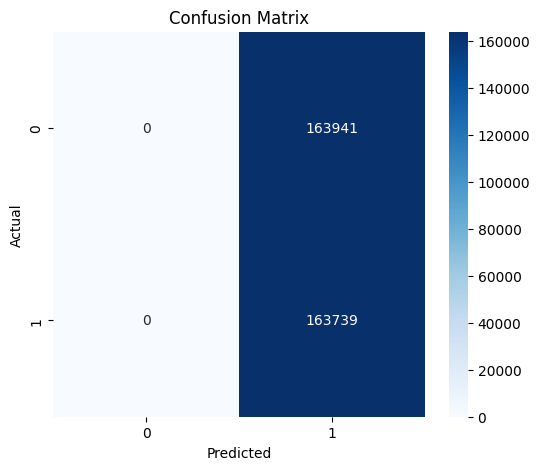

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    163941
         1.0       0.50      1.00      0.67    163739

    accuracy                           0.50    327680
   macro avg       0.25      0.50      0.33    327680
weighted avg       0.25      0.50      0.33    327680



c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\my_new_environment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


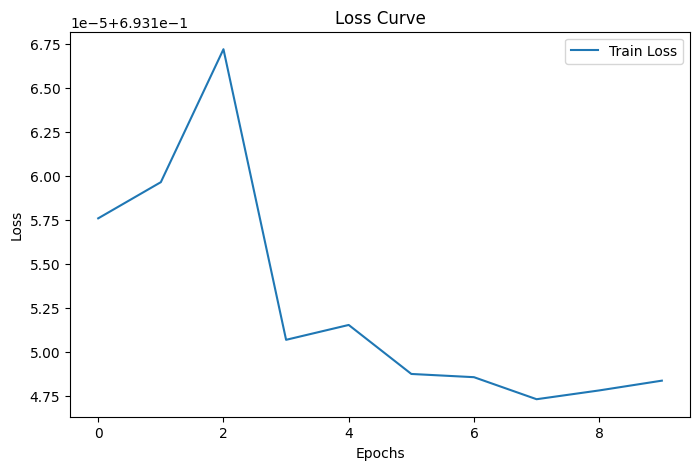

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Define U-Net model in PyTorch
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck = self.conv_block(128, 256)
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        self.up2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(64, 64)
        
        # Output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.pool(x1)
        x3 = self.enc2(x2)
        x4 = self.pool(x3)
        x5 = self.bottleneck(x4)
        x6 = self.up1(x5)
        x7 = self.dec1(x6)
        x8 = self.up2(x7)
        x9 = self.dec2(x8)
        output = torch.sigmoid(self.final(x9))
        return output

# Generate dummy dataset
train_images = torch.rand(100, 1, 128, 128)
train_labels = torch.randint(0, 2, (100, 1, 128, 128), dtype=torch.float32)
test_images = torch.rand(20, 1, 128, 128)
test_labels = torch.randint(0, 2, (20, 1, 128, 128), dtype=torch.float32)

# Create DataLoader
def get_dataloader(images, labels, batch_size=8):
    dataset = data.TensorDataset(images, labels)
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = get_dataloader(train_images, train_labels)
test_loader = get_dataloader(test_images, test_labels, batch_size=4)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, epochs=10):
    model.train()
    train_loss = []
    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss[-1]:.4f}")
    return train_loss

train_loss = train_model(model, train_loader)

# Evaluate model and plot results
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            all_preds.append(preds.cpu().numpy().flatten())
            all_labels.append(labels.cpu().numpy().flatten())
    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n", classification_report(y_true, y_pred))

def plot_loss_curve(train_loss):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.show()

evaluate_model(model, test_loader)
plot_loss_curve(train_loss)


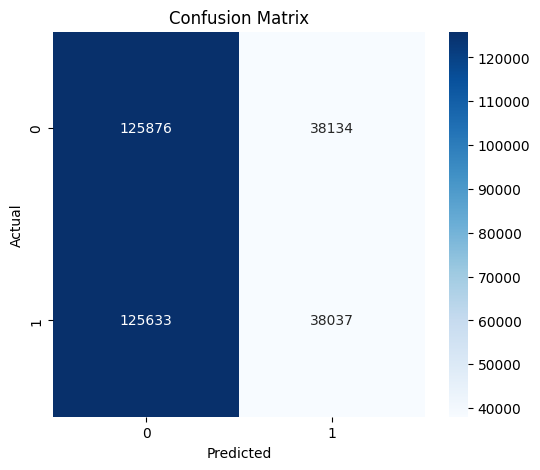

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.77      0.61    164010
           1       0.50      0.23      0.32    163670

    accuracy                           0.50    327680
   macro avg       0.50      0.50      0.46    327680
weighted avg       0.50      0.50      0.46    327680



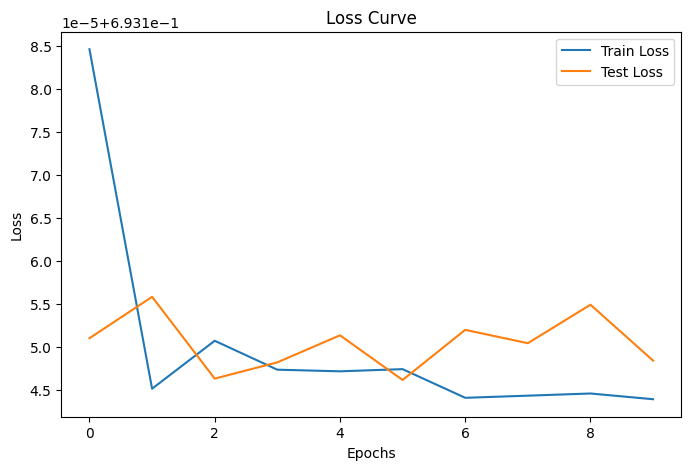

In [3]:
# nfull projected code
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, Dataset

# Define U-Net model in PyTorch
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck
        self.bottleneck = self.conv_block(128, 256)
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(64, 64)
        
        # Output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
    
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.pool(x1)
        x3 = self.enc2(x2)
        x4 = self.pool(x3)
        x5 = self.bottleneck(x4)
        x6 = self.up1(x5)
        x7 = self.dec1(x6)
        x8 = self.up2(x7)
        x9 = self.dec2(x8)
        return self.sigmoid(self.final(x9))

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
        self.labels = torch.tensor(labels, dtype=torch.float32).permute(0, 3, 1, 2)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Load dataset
train_images = np.random.rand(100, 128, 128, 1)  # Placeholder data
train_labels = np.random.randint(0, 2, (100, 128, 128, 1))
test_images = np.random.rand(20, 128, 128, 1)
test_labels = np.random.randint(0, 2, (20, 128, 128, 1))

train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses, test_losses, train_accs, test_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        total_loss, correct, total = 0, 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
        test_losses.append(total_loss / len(test_loader))

# Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).cpu().numpy().astype(int)
            labels = labels.cpu().numpy().astype(int)
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.flatten())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    print("Classification Report:\n", classification_report(all_labels, all_preds))

def plot_loss_curve(train_losses, test_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.show()

evaluate_model(model, test_loader)
plot_loss_curve(train_losses, test_losses)



In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skimage import measure
from sklearn.metrics import (precision_recall_fscore_support, jaccard_score, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, 
                             cohen_kappa_score, roc_auc_score, roc_curve, auc)
import seaborn as sns

# Add the function to plot confusion matrix and ROC curve
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    return roc_auc

# Modify evaluation function to include confusion matrix and ROC curve
def evaluate_model(model, test_loader, threshold=0.5, visualize=True, num_visualizations=3):
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            preds = (probs > threshold).astype(int)
            masks = masks.cpu().numpy().flatten()
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_targets.extend(masks)
    
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='binary')
    jaccard = jaccard_score(all_targets, all_preds)
    accuracy = accuracy_score(all_targets, all_preds)
    
    print("\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Jaccard Score: {jaccard:.4f}")
    
    plot_confusion_matrix(all_targets, all_preds, classes=['No Sunspot', 'Sunspot'])
    roc_auc = plot_roc_curve(all_targets, all_probs)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "jaccard": jaccard, "roc_auc": roc_auc}

# Modify train_model to plot accuracy and loss curves
def train_model(model, train_loader, val_loader, epochs=20, lr=1e-4, accumulation_steps=4):
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
    criterion = nn.BCEWithLogitsLoss()

    best_loss = float('inf')
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    model_path = os.path.expanduser("~/saved_models/sunspot_unet_minimal.pth")
    os.makedirs(os.path.dirname(model_path), exist_ok=True)

    for epoch in range(epochs):
        model.train()
        correct_train, total_train, epoch_train_loss = 0, 0, 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            preds = torch.sigmoid(outputs).detach().cpu().numpy() > 0.5
            correct_train += (preds == masks.cpu().numpy()).sum()
            total_train += masks.numel()
            epoch_train_loss += loss.item()

        train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        
        model.eval()
        correct_val, total_val, epoch_val_loss = 0, 0, 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
                correct_val += (preds == masks.cpu().numpy()).sum()
                total_val += masks.numel()
                epoch_val_loss += loss.item()

        val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        
        scheduler.step(val_losses[-1])
        
        if val_losses[-1] < best_loss:
            best_loss = val_losses[-1]
            torch.save(model.state_dict(), model_path)
            print(f"Model saved to {model_path}")
        
        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.show()
    
    return model_path


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skimage import measure
from sklearn.metrics import precision_recall_fscore_support, jaccard_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, roc_auc_score, roc_curve, auc
import seaborn as sns

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ================ Dataset Implementation ================
class SunspotDataset(Dataset):
    def __init__(self, img_dir, img_size=(224, 224)):
        self.img_dir = img_dir
        self.img_size = img_size
        self.img_files = [f for f in os.listdir(img_dir)
                          if os.path.isfile(os.path.join(img_dir, f)) and
                          f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.img_files)

    def _correct_limb_darkening(self, image):
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        radius = min(w, h) // 2
        Y, X = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
        normalized_dist = np.clip(dist_from_center / radius, 0, 1)
        a, b, c = 0.3, 0.5, 0.2
        correction = 1 / (1 - a * (1 - np.sqrt(1 - normalized_dist**2)) -
                             b * (1 - np.sqrt(1 - normalized_dist**2))**2 -
                             c * (1 - np.sqrt(1 - normalized_dist**2))**3)
        corrected_img = image.copy().astype(np.float32)
        for i in range(3):
            channel = corrected_img[:, :, i]
            solar_disk_mask = dist_from_center <= radius
            channel[solar_disk_mask] = channel[solar_disk_mask] * correction[solar_disk_mask]
        corrected_img = np.clip(corrected_img, 0, 255).astype(np.uint8)
        return corrected_img

    def _enhance_contrast(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        enhanced_lab = cv2.merge((cl, a, b))
        enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
        return enhanced_rgb

    def _reduce_noise(self, image):
        return cv2.GaussianBlur(image, (3, 3), 0)

    def preprocess_image(self, image_path):
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image at {image_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)
        image = self._correct_limb_darkening(image)
        image = self._enhance_contrast(image)
        image = self._reduce_noise(image)
        return image

    def generate_mask(self, image):
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
        gray_float = (255 - gray.astype(np.float32)) / 255.0
        normalized = cv2.normalize(gray_float, None, 0, 1, cv2.NORM_MINMAX)
        _, binary = cv2.threshold((normalized * 255).astype(np.uint8), 0, 255,
                                    cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
        labeled_array, num_features = measure.label(opening, return_num=True)
        component_sizes = np.bincount(labeled_array.ravel())
        small_size_threshold = 20
        too_small = component_sizes < small_size_threshold
        too_small[0] = False
        labeled_array[np.isin(labeled_array, np.where(too_small)[0])] = 0
        final_mask = labeled_array > 0
        return final_mask.astype(np.uint8) * 255

# ================ Evaluation Metrics Addition ================
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def evaluate_and_plot(model, test_loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            preds = (probs > 0.5).astype(int)
            y_true.extend(masks.cpu().numpy().flatten())
            y_pred.extend(preds)
            y_probs.extend(probs)

    plot_confusion_matrix(y_true, y_pred)
    plot_roc_curve(y_true, y_probs)


# ================ Main Execution ================
def main(data_dir):
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')

    train_dataset = SunspotDataset(train_dir)
    test_dataset = SunspotDataset(test_dir)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    batch_size = 2
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = UNet(in_channels=3, out_channels=1, features=[64, 128]) # Increased features

    model_path = train_model(model, train_loader, val_loader, epochs=30, accumulation_steps=4)

    try:
        model.load_state_dict(torch.load(model_path))
        print(f"Model loaded from {model_path}")
    except Exception as e:
        print(f"Failed to load model: {e}")
        print("Using current model state for evaluation")

    metrics = evaluate_model(model, test_loader, visualize=True, num_visualizations=3)

    print("\nEvaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

    new_image_path = "C:\Users\chris\Downloads\sunspot -1.jpg"
    infer_single_image(new_image_path, model)

    return model, metrics

if __name__ == "__main__":
    data_directory = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"
    main(data_directory)
 